### Описание проекта

Вы аналитик популярного сервиса аренды самокатов GoFast. Вам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируйте данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти.

Пользователи user_go.csv: 
1) user_id - уникальный идентификатор пользователя

2) name -	имя пользователя

3) age - возраст

4) city - город

5) subscription_type - тип подписки (free, ultra)

Поездки rides_go.csv : 

1) user_id - уникальный идентификатор пользователя

2) distance - расстояние, которое пользователь проехал в текущей сессии (в метрах)

3) duration - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»

4) date - дата совершения поездки

Подписки subscriptions_go.csv : 

1) subscription_type - тип подписки

2) minute_price - стоимость одной минуты поездки по данной подписке

3) start_ride_price - стоимость начала поездки

4) subscription_fee - стоимость ежемесячного платежа

In [ ]:
### Добавление библиотек

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import warnings

#### Шаг 1. Загрузка данных

In [2]:
# Считываю файлы с данными и сохраняю в датафреймы
users = pd.read_csv('/datasets/users_go.csv')
rides = pd.read_csv('/datasets/rides_go.csv')
subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')

In [3]:
# Вывожу общие данные по датафрейму и вывожу первые 5 значений для ознакомления
display(users.describe())
display(users.info())
display(users.head())

,user_id,age
count,1565.000000,1565.000000
mean,762.633866,24.922045
std,443.260155,4.553496
min,1.000000,12.000000
25%,378.000000,22.000000
50%,762.000000,25.000000
75%,1146.000000,28.000000
max,1534.000000,43.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


None

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
# Также вывожу общие данные по датафрейму и вывожу первые 5 значений для ознакомления
display(rides.head())
display(rides.info())
display(rides.describe())

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


None

,user_id,distance,duration
count,18068.000000,18068.000000,18068.000000
mean,842.869936,3070.659976,17.805011
std,434.734317,1116.831209,6.091051
min,1.000000,0.855683,0.500000
25%,487.000000,2543.226360,13.597563
50%,889.000000,3133.609994,17.678395
75%,1213.250000,3776.222735,21.724800
max,1534.000000,7211.007745,40.823963


In [5]:
# Здесь общая информация не требуется, т.к. датафрейм достаточно прост
display(subscriptions.head())
display(subscriptions.info())

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


None

Загрузил 3 датафрейма, ознакомился с ними, могу сделать следующий вывод:
Можно заметить, что тип данных столбца 'date' в rides_go.csv записано некорректно, что буду исправлять в следующем шаге.

#### Шаг 2. Предобработка данных

In [7]:
# Изменяю тип данных на столбце date
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')

In [8]:
# Добавляю вспомогательный столбец с месяцем
rides['month'] = pd.DatetimeIndex(rides['date']).month

In [9]:
# Определяем пропущенные значения
display(users.isna().sum())
# Определяем процент пропущенных значений
display(users.isna().mean())
# Определяем дубликаты
display(users.duplicated().sum())
# Выявили 31 дубликат. Удаляем дубликаты и перепроверяем их наличие
users = users.drop_duplicates(subset=['user_id'], keep='first')
users = users.reset_index(drop=True)
display(users.duplicated().sum())

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

user_id              0.0
name                 0.0
age                  0.0
city                 0.0
subscription_type    0.0
dtype: float64

31

0

In [10]:
# Определяем пропущенные значения
display(rides.isna().sum())
# Определяем процент пропущенных значений
display(rides.isna().mean())
# Определяем дубликаты
display(rides.duplicated().sum())

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

user_id     0.0
distance    0.0
duration    0.0
date        0.0
month       0.0
dtype: float64

0

In [11]:
# Определяем пропущенные значения
display(subscriptions.isna().sum())
# Определяем процент пропущенных значений
display(subscriptions.isna().mean())
# Определяем дубликаты
display(subscriptions.duplicated().sum())

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

subscription_type    0.0
minute_price         0.0
start_ride_price     0.0
subscription_fee     0.0
dtype: float64

0

На этапе предобработки данных я изменил тип данных в "rides" на datetime, а также выявил дубликаты в датафрейме 'users' в количестве 31 штуки. После успешного удаления, 

#### Шаг 3. Исследовательский анализ данных

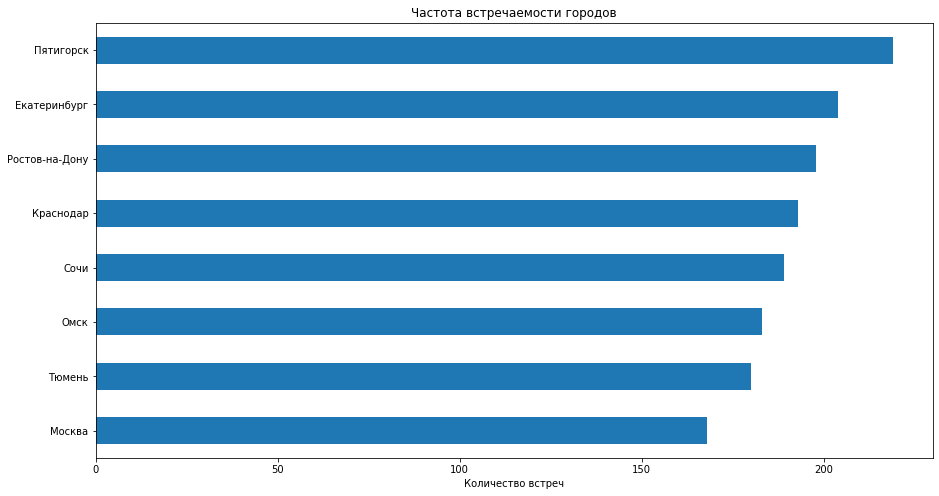

In [13]:
# 3.1 частота встречаемости городов
fig, ax = plt.subplots(figsize=(15,8))
users['city'].value_counts().sort_values(ascending=True).plot(kind='barh');
ax.set_title('Частота встречаемости городов')
ax.set_xlabel('Количество встреч')
plt.show()

Исходя из этого графика, видно, что большинство заказов приходится в городе Пятигорск, но меньше всего, арендуют в Москве

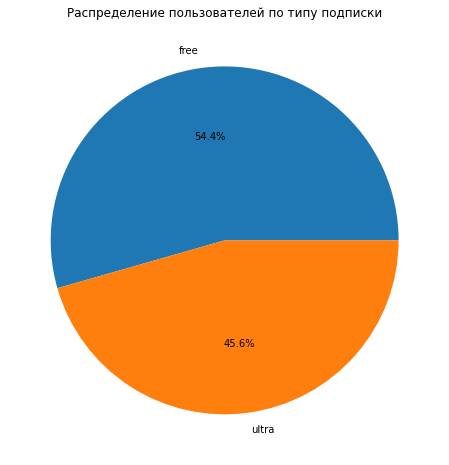

In [14]:
# 3.2 соотношение пользователей с подпиской и без подписки
fig, ax = plt.subplots(figsize=(8,8))
users['subscription_type'].value_counts().plot(kind='pie', figsize=(8,8), autopct='%1.1f%%')
ax.set_title('Распределение пользователей по типу подписки')
ax.set_ylabel('')
plt.show()

Пользователей без подписки больше на 10%

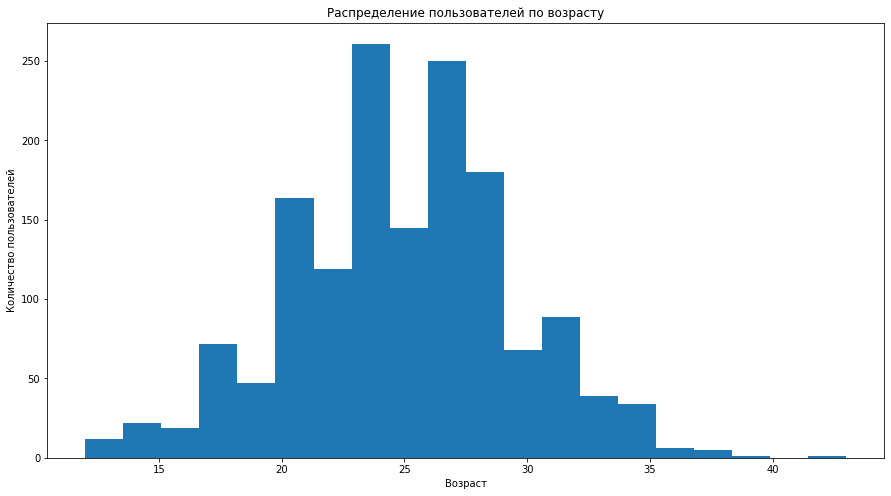

In [15]:
# 3.3 возраст пользователей;
fig, ax = plt.subplots(figsize=(15,8))
users['age'].plot(kind='hist', bins=20, figsize=(15,8))
ax.set_title('Распределение пользователей по возрасту')
ax.set_ylabel('Количество пользователей')
ax.set_xlabel('Возраст')
plt.show()

Основными пользователями нашего приложения являются 20-29 летние. Очень редко можно встретить пользователей за 35.

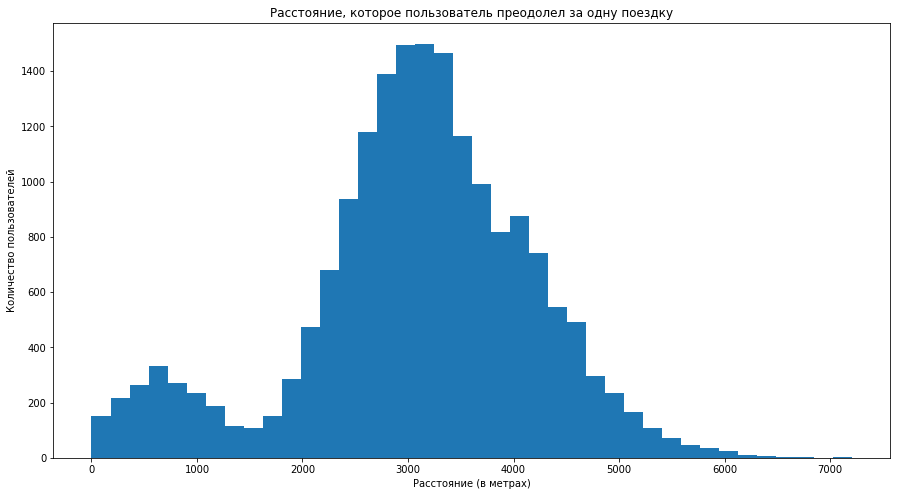

In [16]:
# 3.4 Расстояние, которое пользователь преодолел за одну поездку;
fig, ax = plt.subplots(figsize=(15,8))
rides['distance'].plot(kind='hist', bins=40)
ax.set_ylabel('Количество пользователей')
ax.set_xlabel('Расстояние (в метрах)')
ax.set_title('Расстояние, которое пользователь преодолел за одну поездку')
plt.show()

Пользователи проезжают в основном от 2 до 4.5 километров. Если исключения, где пользователи могли ездить от 6 километров.

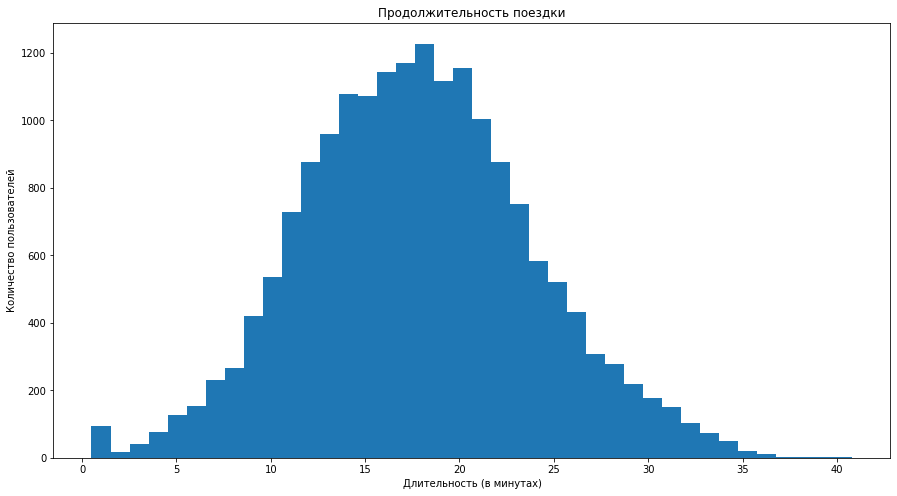

In [17]:
# 3.5 продолжительность поездок.
fig, ax = plt.subplots(figsize=(15,8))
rides['duration'].plot(kind='hist', bins=40)
ax.set_ylabel('Количество пользователей')
ax.set_xlabel('Длительность (в минутах)')
ax.set_title('Продолжительность поездки')
plt.show()

Арендуют самокаты в основном от 9 до 26 минут. Дольше 35 минут почти никто не арендовал

#### Шаг 4. Объединение данных

In [19]:
# Объедияю данные о пользователях, поездках и подписках в один датафрейм.
df = users.merge(rides, on='user_id', how='left')
df = df.merge(subscriptions, on='subscription_type', how='left')
df.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


In [20]:
# Создаю отдельный датафрейм БЕЗ подписки
df_wo = df.query("subscription_type == 'free'")

In [21]:
# И отдельно с подпиской
df_with = df.query("subscription_type == 'ultra'")

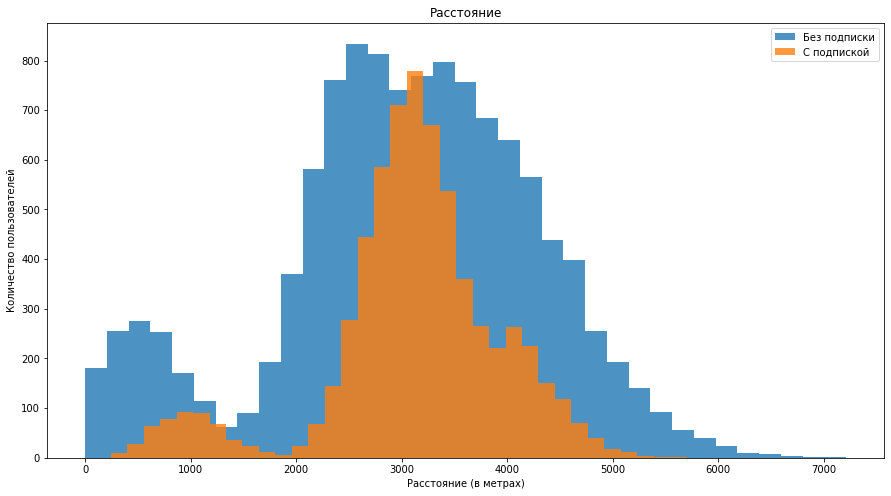

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

In [22]:
# Строю визуализацию по расстоянию
fig, ax = plt.subplots(figsize=(15,8))
ax.hist(df_wo['distance'], bins=35, label='Без подписки', alpha=0.8)
ax.hist(df_with['distance'], bins=35, label='С подпиской', alpha=0.8)
ax.set_title('Расстояние')
ax.set_ylabel('Количество пользователей')
ax.set_xlabel('Расстояние (в метрах)')
plt.legend()
plt.show()
display(df_wo['distance'].describe())
display(df_with['distance'].describe())

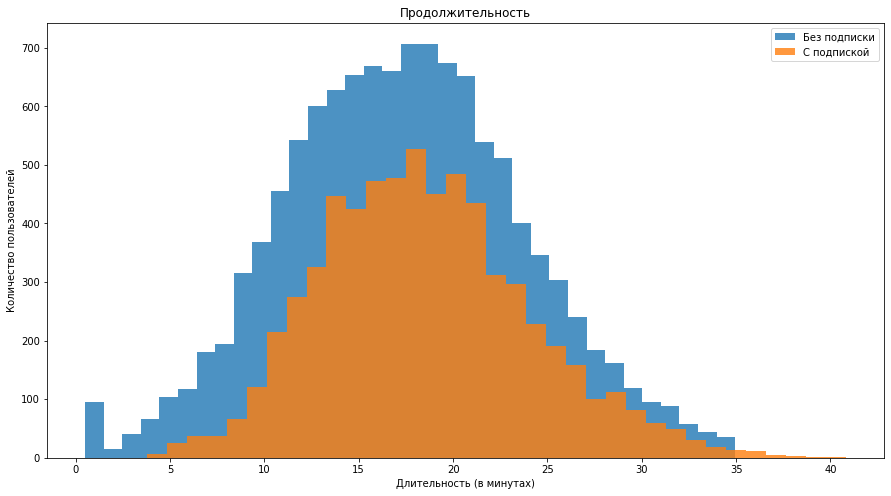

count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

In [23]:
# Строю визуализацию по расстоянию
fig, ax = plt.subplots(figsize=(15,8))
ax.hist(df_wo['duration'], bins=35, label='Без подписки', alpha=0.8)
ax.hist(df_with['duration'], bins=35, label='C подпиской', alpha=0.8)
ax.set_title('Продолжительность')
ax.set_ylabel('Количество пользователей')
ax.set_xlabel('Длительность (в минутах)')
plt.legend()
plt.show()
display(df_wo['duration'].describe())
display(df_with['duration'].describe())

Общий вывод по графикам:

    Пользователи без подписки в среднем проходят расстояние от 2.3 до 4 км и арендуют самокаты от 12 до 21 минут.
    Пользователи с подпиской в среднем проходят расстояние от 2.7 до 3.5 км и также арендуют самокаты от 14 до 21 минут.

#### Шаг 5. Подсчёт выручки

In [27]:
# Округляю значения длительности для того, чтобы в дальнейшем корректно создать датафрейм с помесячной выручкой
warnings.filterwarnings("ignore")
df_wo['duration'] = np.ceil(df_wo['duration'])
df_with['duration'] = np.ceil(df_with['duration'])

In [28]:
# Создаю агрегированный датафрейм с пользователями без подписки
df_wo_agg = df_wo.groupby(['user_id', 'month']).agg({'distance':['count','sum'], 'duration':'sum'})

In [29]:
# Создаю агрегированный датафрейм с пользователями с подпиской
df_with_agg = df_with.groupby(['user_id', 'month']).agg({'distance':['count','sum'], 'duration':'sum'})

In [30]:
# Применяю функцию, где добавляю расчет с помесячной выручкой для пользователей без подписки
def monthly_cost_wo(rows_values):
    count = rows_values['distance']['count']
    duration = rows_values['duration']['sum']
    month_cost = (50 * count) + (8 * duration)
    return month_cost
                                     
df_wo_agg['cost'] = df_wo_agg.apply(monthly_cost_wo, axis=1)
df_wo_agg.columns = ['count', 'distance', 'duration', 'cost']
df_wo_agg.head(10)

count      distance  duration   cost
user_id month                                      
700     1          1   2515.690719      15.0  170.0
        2          5  13446.659764      89.0  962.0
        3          1   3798.334905      19.0  202.0
        4          1   2984.551206      16.0  178.0
        6          2   5927.650988      29.0  332.0
        7          2   4399.206279      21.0  268.0
        8          1   4071.654669      17.0  186.0
        10         2   6322.578618      44.0  452.0
        11         3   8735.782625      32.0  406.0
701     1          1   2676.472894      18.0  194.0

In [31]:
# Применяю функцию, где добавляю расчет с помесячной выручкой для пользователей с подпиской
def monthly_cost_with(rows_values):
    count = rows_values['distance']['count']
    duration = rows_values['duration']['sum']
    month_cost = 199 + (6 * duration)
    return month_cost
                                     
df_with_agg['cost'] = df_with_agg.apply(monthly_cost_with, axis=1)
df_with_agg.columns = ['count', 'distance', 'duration', 'cost']
df_with_agg.head(10)

count      distance  duration   cost
user_id month                                      
1       1          2   7027.511294      42.0  451.0
        4          1    754.159807       7.0  241.0
        8          2   6723.470560      46.0  475.0
        10         2   5809.911100      32.0  391.0
        11         3   7003.499363      56.0  535.0
        12         2   6751.629942      28.0  367.0
2       3          3  10187.723006      63.0  577.0
        4          2   6164.381824      40.0  439.0
        6          1   3255.338202      14.0  283.0
        7          2   6780.722964      48.0  487.0

#### Шаг 6. Проверка гипотез

1) Проверка гипотезы: Тратят ли пользователи с подпиской больше времени на поездки

        H_0: Длительность поездки у пользователей с подпиской и без неё, равна 
        H_a: Длительность поездки у пользователей с подпиской больше чем у пользователей без подписки
        alpha = 0.05

In [ ]:
# Проверяю гипотезу по длительности между пользователями с подпиской и без подписки
results = st.ttest_ind(df_wo['duration'], df_with['duration'], alternative='less')
p_value = results.pvalue
duration_diff = df_with['duration'].mean() - df_wo['duration'].mean()
if results.pvalue < 0.05:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
print("Значение p-value:", p_value)
print("Средняя длительность:", duration_diff)

Отвергаем нулевую гипотезу
Значение p-value: 2.4959453720736625e-34
Средняя длительность: 1.146699914884561


Вывод: Проверка гипотезы показала, что длительность поездки у пользователей с подпиской больше чем у пользователей без подписки

2) Проверка гипотезы: Расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров

        H_0: Среднее расстояние пользователей с подпиской равно 3130 метров
        H_a: Среднее расстояние пользователей с подпиской не превышает 3130 метров
        alpha = 0.05

In [33]:
# Проверяю гипотезу по износу самоката среди пользователей с подпиской
results = st.ttest_1samp(df_with['distance'], 3130, alternative='less')
p_value = results.pvalue
mean_distance = df_with['distance'].mean()
if results.pvalue < 0.05:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
print("Значение p-value:", p_value)
print("Среднее расстояние:", mean_distance)

Не получилось отвергнуть нулевую гипотезу
Значение p-value: 0.08046311521502146
Среднее расстояние: 3115.4453880370247


Вывод: Проверка гипотезы показала, что cреднее расстояние пользователей с подпиской превышает или равно 3130 метров

3) Проверка гипотезы: Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки

        H_0: Выручка от пользователей без подписки выше или равна чем от пользователей с подпиской
        H_a: Выручка от пользователей с подпиской выше чем от пользователей без подписки
        alpha = 0.05

In [34]:
# Проверяю гипотезу по разнице в помесячной выручке между разными типами пользователей
results = st.ttest_ind(df_wo_agg['cost'], df_with_agg['cost'], alternative='less')
p_value = results.pvalue
diff_cost = df_with_agg['cost'].mean() - df_wo_agg['cost'].mean()
if (results.pvalue / 2 < 0.05 and (df_with_agg['cost'].mean() > df_wo_agg['cost'].mean())):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
print(df_with_agg['cost'].mean() > df_wo_agg['cost'].mean())
print("Значение p-value:", p_value)
print("Разница в выручке:", diff_cost)

Отвергаем нулевую гипотезу
True
Значение p-value: 1.8850394384715216e-31
Разница в выручке: 34.15082549486567


Вывод: Проверка гипотезы показала, что выручка от пользователей с подпиской выше чем от пользователей без подписки

#### Общий вывод


Я провел исследовательский анализ данных, подсчитал выручку у пользователей с подпиской и без, проверил несколько гипотез и по проведенному анализу, могу сделать следующий вывод, что пользователи с подпиской Ultra являются более выгодными, т.к. выручка от них больше.

Но стоит взять во внимание и тот факт, что пользователи с подпиской преодолевают больше растояния чем пользователи без подписки и превышают оптимальное расстояние для износа самоката, что может повлечь за собой дополнительные расходы на обслуживание и ремонт.